# cargar datos


In [14]:
import os 
import json
src_path = "archive/mmimdb/dataset/"
ids = [x.split(".")[0] for x in os.listdir(src_path) if x.endswith(".jpeg")]
horror_ids = []
drama_ids = []
print('how many', len(ids))
while len(horror_ids) < 2000 and len(drama_ids) < 2000:
        for id in ids:
            file = f"{src_path}{id}.json"
            with open(file, "r") as f:
                metadata_f = json.load(f)
            genres = metadata_f["genres"]
            #exclude those with both labels
            if "Horror" in genres and "Drama" in genres:
                horror_ids.append(id)
            if "Drama" in genres and "Horror" not in genres:
                drama_ids.append(id)

In [15]:
# split 
from sklearn.model_selection import train_test_split


ids = horror_ids + drama_ids
labels = [0] * len(horror_ids) + [1] * len(drama_ids)

X_train, X_valid_, y_train, y_valid_ = train_test_split(
    ids, labels, test_size=0.4, random_state=42, stratify=labels
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_, y_valid_, test_size=0.5, random_state=42, stratify=y_valid_
)


In [16]:
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image, ImageReadMode
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, ids, labels, transform=None):
        self.image_folder = image_folder
        self.ids = ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_path = self.image_folder + self.ids[idx] + ".jpeg"
        # Open the image and convert it to RGB
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



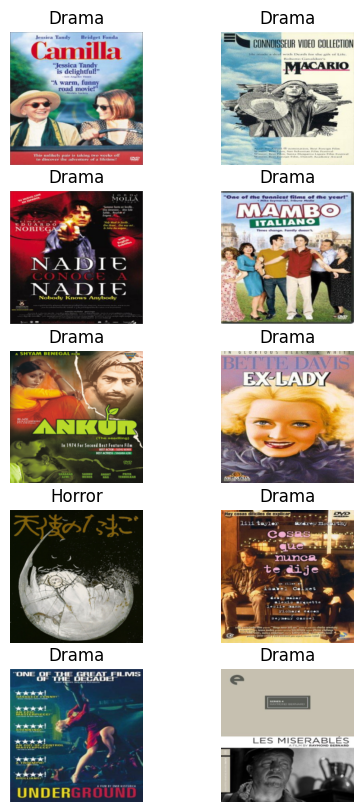

In [17]:
import matplotlib.pyplot as plt
a = ImageDataset(src_path, X_train, y_train, transform=T.Compose([T.Resize((224, 224)), T.ToTensor()]))
# Assuming X_test is the list of image file names
num_images = 10
plt.figure(figsize=(5, 10))
# Loop through the first 10 images in X_test
for i in range(num_images):
    plt.subplot(5,2, i+1)
    # Load and plot the image
    plt.imshow(a.__getitem__(i)[0].permute(1, 2, 0))
    title = "Horror" if a.__getitem__(i)[1] == 0 else "Drama"
    plt.title(title)
    plt.axis('off')
plt.show()


In [18]:
a.__getitem__(i)[0].shape

torch.Size([3, 224, 224])

In [19]:
# image resize transformation
img_height, img_width = 512, 512
transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize((img_height, img_width)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    
    ]
)

train_ds = ImageDataset(src_path, X_train, y_train, transform=transform)
valid_ds = ImageDataset(src_path, X_valid, y_valid, transform=transform)
test_ds = ImageDataset(src_path, X_test, y_test, transform=transform)


In [20]:
batch_size = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
loader_args = dict(
    batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True
)
train_dl = DataLoader(train_ds,  **loader_args)
valid_dl = DataLoader(valid_ds,  **loader_args)
test_dl = DataLoader(test_ds,  **loader_args)


In [21]:
import torch
import torchvision.models as models
import torch.nn as nn
# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)


# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print the model architecture
print(model)

c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:

num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
total_steps = len(train_dl) * num_epochs

for epoch in range(num_epochs):
    model.train()
    for step, (images, labels) in enumerate(train_dl):
        # Calculate the current step
        current_step = epoch * len(train_dl) + step
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (step+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{current_step+1}/{total_steps}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total}%')

c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/5], Step [100/8380], Loss: 0.0201
Epoch [1/5], Step [200/8380], Loss: 0.7138
Epoch [1/5], Step [300/8380], Loss: 0.0951


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [400/8380], Loss: 0.0338


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [500/8380], Loss: 0.0346


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [600/8380], Loss: 0.0467


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [700/8380], Loss: 0.0603


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [800/8380], Loss: 0.0850


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [900/8380], Loss: 0.0268
Epoch [1/5], Step [1000/8380], Loss: 0.0218
Epoch [1/5], Step [1100/8380], Loss: 0.0134
Epoch [1/5], Step [1200/8380], Loss: 0.0330
Epoch [1/5], Step [1300/8380], Loss: 0.0504


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [1400/8380], Loss: 0.0252


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/5], Step [1500/8380], Loss: 0.0319
Epoch [1/5], Step [1600/8380], Loss: 0.0490


c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (100419400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation Accuracy: 96.27640529896169%
Epoch [2/5], Step [1776/8380], Loss: 0.0278
Epoch [2/5], Step [1876/8380], Loss: 0.0722
Epoch [2/5], Step [1976/8380], Loss: 0.0429
Epoch [2/5], Step [2076/8380], Loss: 0.0932
Epoch [2/5], Step [2176/8380], Loss: 0.0221
Epoch [2/5], Step [2276/8380], Loss: 0.0414
Epoch [2/5], Step [2376/8380], Loss: 0.5349
Epoch [2/5], Step [2476/8380], Loss: 0.0240
Epoch [2/5], Step [2576/8380], Loss: 0.0520
Epoch [2/5], Step [2676/8380], Loss: 0.0416
Epoch [2/5], Step [2776/8380], Loss: 0.0419
Epoch [2/5], Step [2876/8380], Loss: 0.0428
Epoch [2/5], Step [2976/8380], Loss: 0.0224
Epoch [2/5], Step [3076/8380], Loss: 0.0299
Epoch [2/5], Step [3176/8380], Loss: 0.0180
Epoch [2/5], Step [3276/8380], Loss: 0.0342
Validation Accuracy: 96.27640529896169%
Epoch [3/5], Step [3452/8380], Loss: 0.1063
Epoch [3/5], Step [3552/8380], Loss: 0.0597
Epoch [3/5], Step [3652/8380], Loss: 0.6403
Epoch [3/5], Step [3752/8380], Loss: 0.0472
Epoch [3/5], Step [3852/8380], Loss: 0.0

In [23]:
model.eval()
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   
        print(f'Test Accuracy: {100 * correct / total}%')

c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (101769871 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\acmor\miniconda3\envs\mlcourse\Lib

Test Accuracy: 96.13457408733%


Tiene un accuracy alto.